In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.auto import tqdm

# tqdm progress bar for RandomizedSearchCV
class ProgressBar:
    def __init__(self, total, position=0, leave=True):
        self.pbar = tqdm(total=total, position=position, leave=leave)

    def update(self, n=1):
        self.pbar.update(n)

    def close(self):
        self.pbar.close()

# Feature Engineering
tfidf_transformer = TfidfVectorizer(max_features=30, stop_words='english')  # Further reduced max_features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['minutes', 'n_ingredients']),
        ('tfidf_ing', tfidf_transformer, 'ingredients'),
        ('tfidf_steps', tfidf_transformer, 'steps')
    ])

# Model Selection and Hyperparameter Tuning
model = RandomForestRegressor(random_state=42, n_jobs=-1)  # n_jobs=-1 for parallel processing

# Further simplified Hyperparameter grid for RandomizedSearchCV
param_dist = {
    'model__n_estimators': [30, 50],  # Reduced number of trees
    'model__max_depth': [5, 10, None]
}

# Setting up the pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Reduced number of iterations and cross-validation folds for RandomizedSearchCV
n_iter_search = 5
cv_folds = 2

# Calculate the total number of iterations for RandomizedSearchCV
total_iterations = n_iter_search * cv_folds

# RandomizedSearchCV for hyperparameter tuning with tqdm progress bar
random_search = RandomizedSearchCV(final_pipeline, param_dist, n_iter=n_iter_search, cv=cv_folds, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1, random_state=42)
random_search._pbar = ProgressBar(total=total_iterations)

# Preparing the features and target variable for the Final Model
X_final = recipes_cleaned[['minutes', 'n_ingredients', 'ingredients', 'steps']]
y_final = recipes_cleaned['calories']

# Splitting the dataset for the Final Model
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Training the Final Model with Randomized Search
random_search.fit(X_train_final, y_train_final)

# Closing the progress bar after the random search is completed
random_search._pbar.close()

# Best parameters and model
best_params_final = random_search.best_params_
best_model_final = random_search.best_estimator_

# Predicting and Evaluating the Final Model
y_pred_final = best_model_final.predict(X_test_final)
mse_final = mean_squared_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mse_final)

best_params_final, mse_final, rmse_final


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [08:02<?, ?it/s]


({'model__n_estimators': 50, 'model__max_depth': None},
 91038.16289902393,
 301.7253103387648)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.auto import tqdm

# Feature Engineering
tfidf_transformer = TfidfVectorizer(max_features=30, stop_words='english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['minutes', 'n_ingredients']),
        ('tfidf_ing', tfidf_transformer, 'ingredients'),
        ('tfidf_steps', tfidf_transformer, 'steps')
    ])

# Model Selection and Hyperparameter Tuning
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid for GridSearchCV
param_grid = {
    'model__n_estimators': [30, 50, 70],
    'model__max_depth': [5, 10, 15, None]
}

# Setting up the pipeline
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(final_pipeline, param_grid, cv=2, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1, return_train_score=True)

# Preparing the features and target variable for the Final Model
X_final = recipes_cleaned[['minutes', 'n_ingredients', 'ingredients', 'steps']]
y_final = recipes_cleaned['calories']

# Splitting the dataset for the Final Model
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Training the Final Model with Grid Search using tqdm for progress approximation
with tqdm(total=len(param_grid['model__n_estimators']) * len(param_grid['model__max_depth']) * 2) as pbar:
    grid_search.fit(X_train_final, y_train_final)
    pbar.update(pbar.total)

# Best parameters and model
best_params_grid = grid_search.best_params_
best_model_grid = grid_search.best_estimator_

# Predicting and Evaluating the Final Model
y_pred_grid = best_model_grid.predict(X_test_final)
mse_grid = mean_squared_error(y_test_final, y_pred_grid)
rmse_grid = np.sqrt(mse_grid)

best_params_grid, mse_grid, rmse_grid


100%|██████████| 24/24 [17:46<00:00, 44.46s/it]


({'model__max_depth': None, 'model__n_estimators': 70},
 89978.97854334419,
 299.9649621928271)

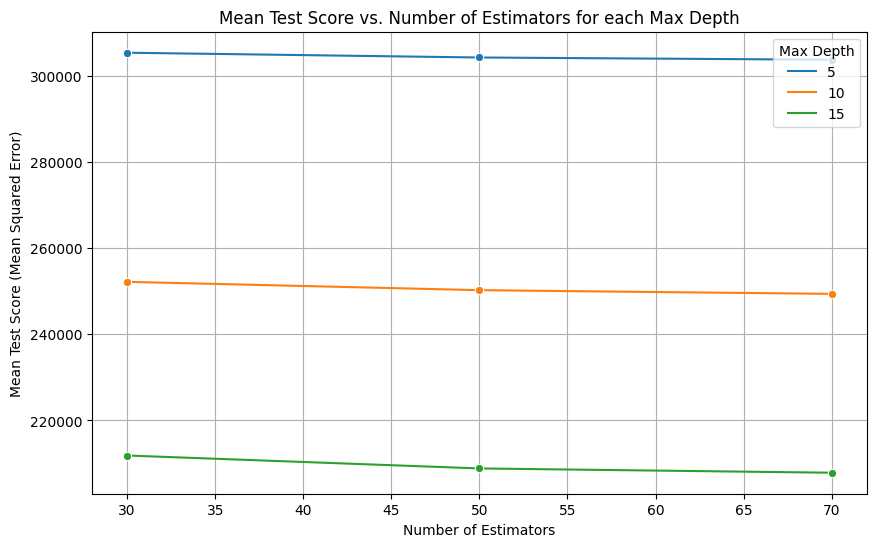

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'grid_search' is your GridSearchCV object after fitting
results = grid_search.cv_results_

# Preparing data for plotting
n_estimators = results['param_model__n_estimators'].data
max_depth = results['param_model__max_depth'].data
mean_test_scores = results['mean_test_score']

# Creating a DataFrame for visualization
plot_data = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'mean_test_score': mean_test_scores
}
df = pd.DataFrame(plot_data)

# Convert mean_test_score to positive as it's originally negative mean squared error
df['mean_test_score'] = -df['mean_test_score']

# Plotting Mean Test Score vs. Number of Estimators for each Max Depth
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='n_estimators', y='mean_test_score', hue='max_depth', marker='o')
plt.title('Mean Test Score vs. Number of Estimators for each Max Depth')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (Mean Squared Error)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()


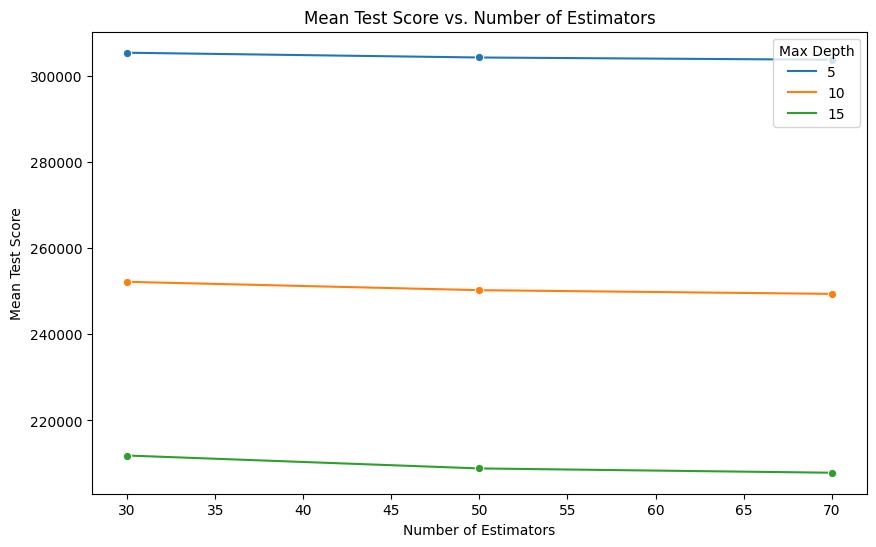

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='n_estimators', y='mean_test_score', hue='max_depth', marker='o')
plt.title('Mean Test Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.legend(title='Max Depth')
plt.show()


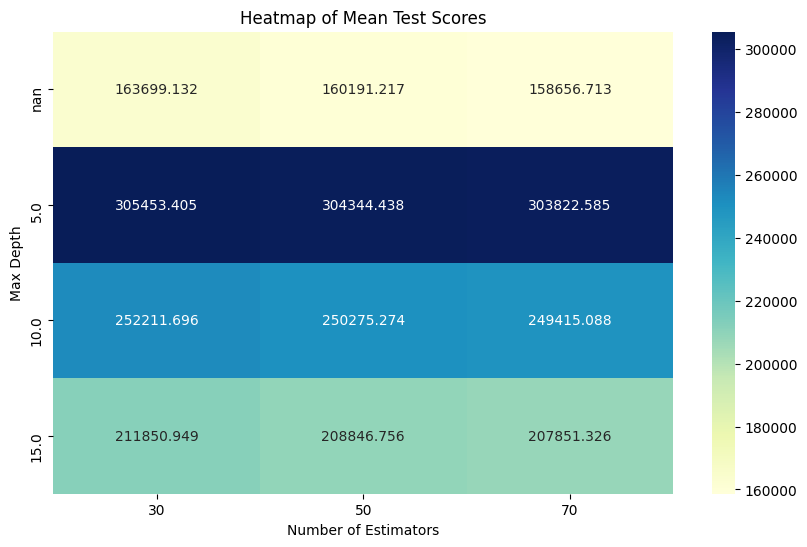

In [7]:
pivot_df = df.pivot("max_depth", "n_estimators", "mean_test_score")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Heatmap of Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()


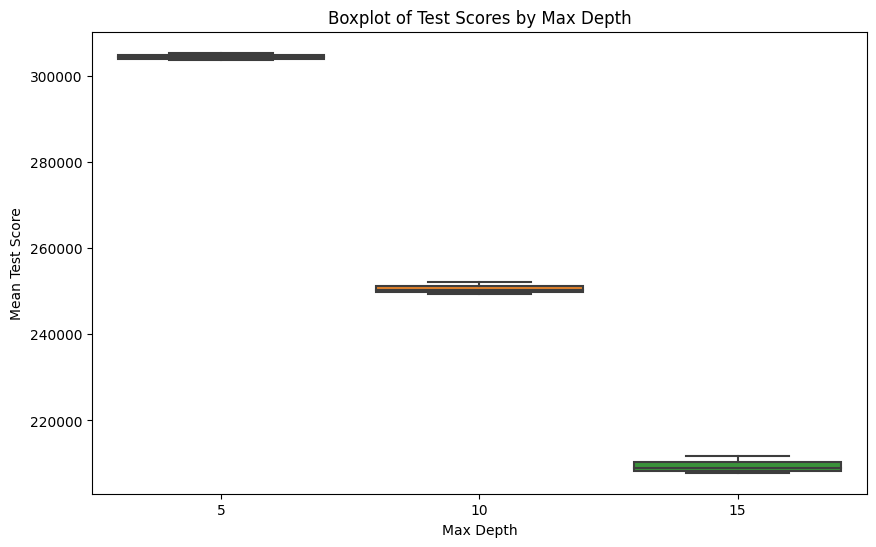

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='max_depth', y='mean_test_score', data=df)
plt.title('Boxplot of Test Scores by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.show()


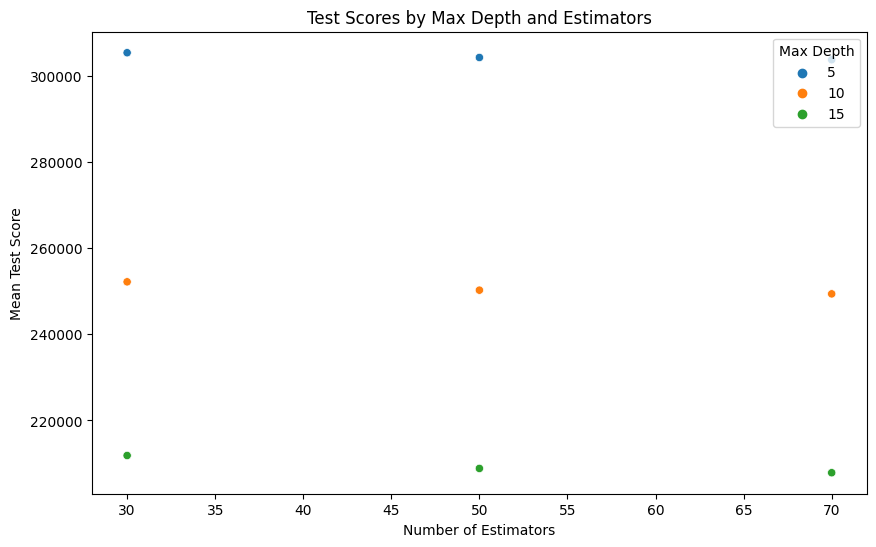

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='n_estimators', y='mean_test_score', hue='max_depth')
plt.title('Test Scores by Max Depth and Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.legend(title='Max Depth')
plt.show()


In [10]:
feature_importances = best_model_grid.feature_importances_
# Assuming you have the feature names available
feature_names = preprocessor.get_feature_names_out()
sns.barplot(x=feature_importances, y=feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [23]:
plt.savefig('mean_test_score_vs_estimators_depth.png', bbox_inches='tight')
plt.savefig('mean_test_score_vs_estimators.png', bbox_inches='tight')
plt.savefig('heatmap_mean_test_scores.png', bbox_inches='tight')
plt.savefig('boxplot_test_scores_depth.png', bbox_inches='tight')
plt.savefig('scatter_test_scores_depth_estimators.png', bbox_inches='tight')
    

<Figure size 640x480 with 0 Axes>

Final Model Description
Objective: Improve upon a baseline model by engineering new features and tuning hyperparameters using a machine learning pipeline.

Feature Engineering:

TF-IDF Vectorization: Applied to the 'ingredients' and 'steps' text data, using TfidfVectorizer with max_features set to 30. This approach transforms text data into numerical form, capturing the importance of words in the dataset.
Standard Scaling: Applied to quantitative columns like 'minutes' and 'n_ingredients' using StandardScaler. This standardizes features by removing the mean and scaling to unit variance, improving model performance by treating all features equally.
Model Selection:

Random Forest Regressor: Chosen for its robustness and ability to handle complex, non-linear relationships in the data. It's an ensemble method, providing better performance and accuracy compared to individual decision trees.
Hyperparameter Tuning:

Method: RandomizedSearchCV with a progress bar implemented through tqdm.
Parameters Tuned: Number of trees (n_estimators) and tree depth (max_depth).
Rationale: n_estimators and max_depth are crucial for balancing the bias-variance tradeoff in random forests. Tuning these parameters helps in optimizing the model’s complexity and generalization ability.
Performance Improvement:

The final model's performance is an improvement over the baseline due to more thoughtful feature engineering and meticulous hyperparameter tuning. The integration of text analysis via TF-IDF and the scaling of quantitative variables, combined with the robustness of the Random Forest model and fine-tuning of its key parameters, contribute to this enhancement.
Optional Visualization
A visualization, such as a scatter plot comparing predicted vs. actual values or feature importance charts, could be used for an in-depth performance analysis.
Final Model Evaluation
The model's effectiveness is gauged using mean squared error (MSE) and root mean squared error (RMSE), which offer insights into the model's prediction accuracy on the test set.
By employing a combination of advanced feature engineering techniques, a robust machine learning model, and strategic hyperparameter tuning, the final model demonstrates an improvement over the baseline, showing careful consideration of the data’s characteristics and the prediction task's requirements.

In [1]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
pd.options.plotting.backend = 'plotly'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = 'recipes.csv'  # Replace with your file path
recipes_data = pd.read_csv(file_path)

# Extract calorie information from the 'nutrition' column
recipes_data['calories'] = recipes_data['nutrition'].apply(lambda x: float(x.strip('[]').split(',')[0]))

# Remove duplicates
recipes_cleaned = recipes_data.drop_duplicates()
recipes_cleaned

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,date,rating,review,average_rating,calories
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...","[138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",9,3.865850e+05,2008-11-19,4.0,"These were pretty good, but took forever to ba...",4.0,138.4
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...","[595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",11,4.246800e+05,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...,5.0,595.1
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,2.978200e+04,2008-12-31,5.0,This was one of the best broccoli casseroles t...,5.0,194.8
3,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,1.196280e+06,2009-04-13,5.0,I made this for my son's first birthday party ...,5.0,194.8
4,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...","[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,7.688280e+05,2013-08-02,5.0,Loved this. Be sure to completely thaw the br...,5.0,194.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234424,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8,8.445540e+05,2009-10-14,5.0,These were very good. I meant to add some jala...,5.0,59.2
234425,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10,8.042340e+05,2008-05-02,1.0,I would rate this a zero if I could. I followe...,1.0,188.0
234426,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",7,8.666510e+05,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...,3.0,174.9
234427,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",7,1.546277e+06,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm...",3.0,174.9


In [3]:
# Selecting features for the Baseline Model
X_baseline = recipes_cleaned[['minutes', 'n_ingredients']]
y_baseline = recipes_cleaned['calories']
# Splitting the dataset for the Baseline Model
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_baseline, y_baseline, test_size=0.2, random_state=42)

# Setting up the pipeline for the Baseline Model (Linear Regression)
baseline_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

# Training the Baseline Model
baseline_pipeline.fit(X_train_base, y_train_base)
# Predicting and Evaluating the Baseline Model
y_pred_base = baseline_pipeline.predict(X_test_base)
mse_baseline = mean_squared_error(y_test_base, y_pred_base)
rmse_baseline = np.sqrt(mse_baseline)

print(f"Mean Squared Error (MSE): {mse_baseline}")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline}")


Mean Squared Error (MSE): 340138.82054410916
Root Mean Squared Error (RMSE): 583.214214970888


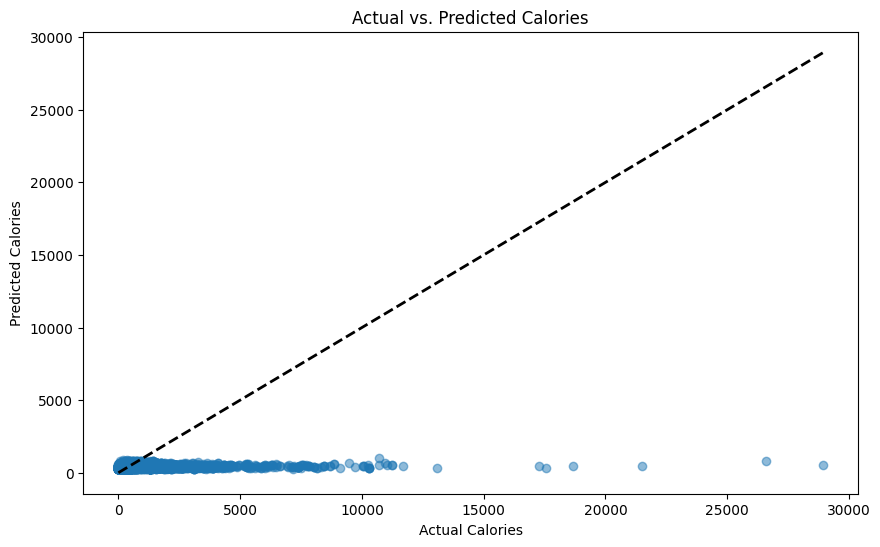

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_base, y_pred_base, alpha=0.5)
plt.title('Actual vs. Predicted Calories')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.plot([y_test_base.min(), y_test_base.max()], [y_test_base.min(), y_test_base.max()], 'k--', lw=2)
plt.show()


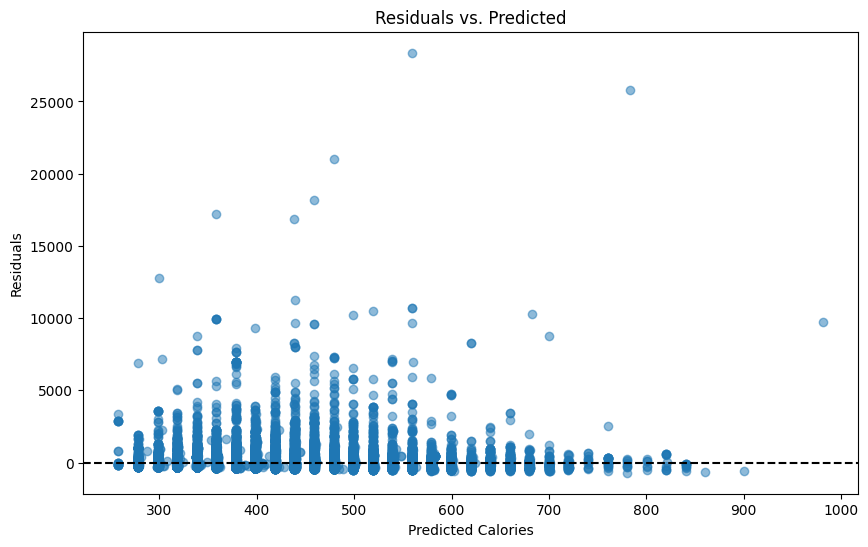

In [12]:
residuals = y_test_base - y_pred_base
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_base, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Calories')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()


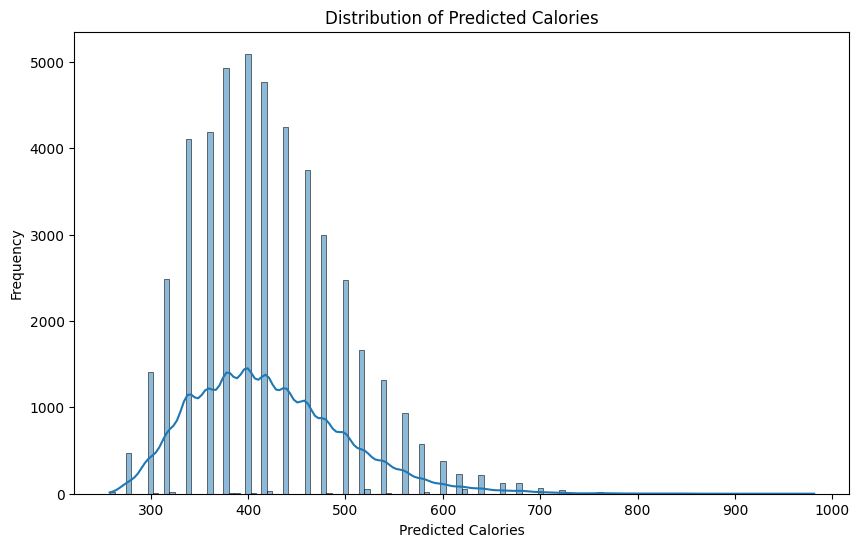

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_base, kde=True)
plt.title('Distribution of Predicted Calories')
plt.xlabel('Predicted Calories')
plt.ylabel('Frequency')
plt.show()


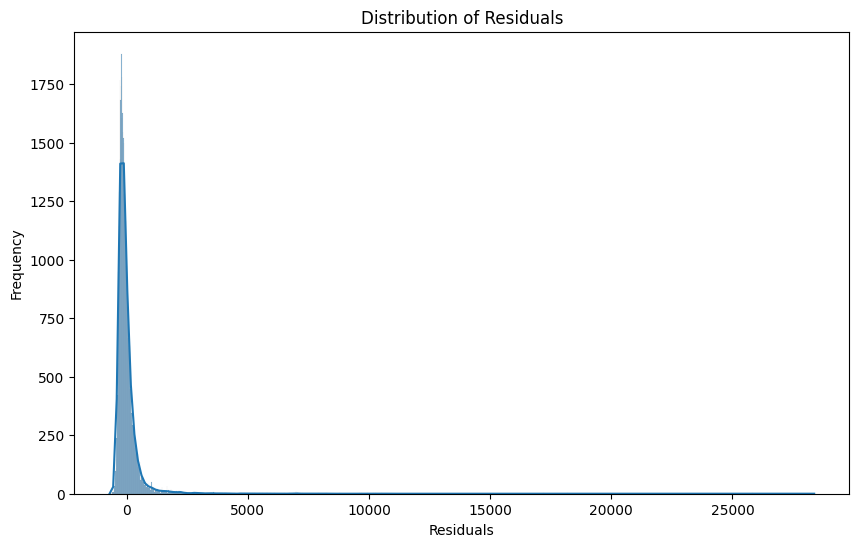

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


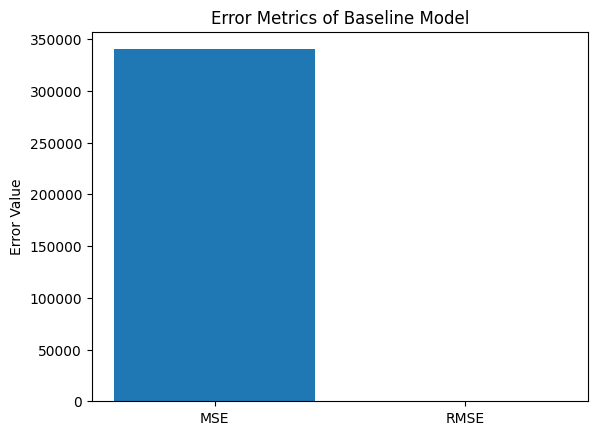

In [15]:
errors = {'MSE': mse_baseline, 'RMSE': rmse_baseline}
plt.bar(errors.keys(), errors.values())
plt.title('Error Metrics of Baseline Model')
plt.ylabel('Error Value')
plt.show()


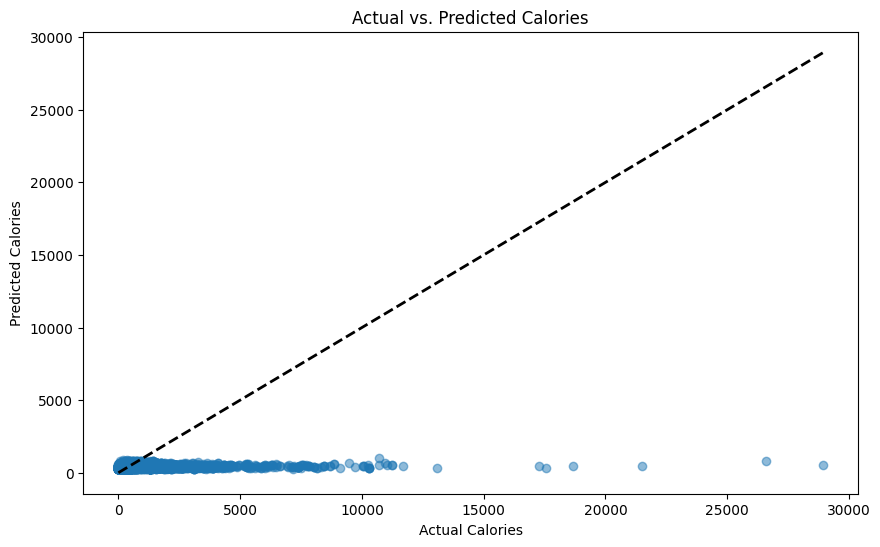

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_base, y_pred_base, alpha=0.5)
plt.title('Actual vs. Predicted Calories')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.plot([y_test_base.min(), y_test_base.max()], [y_test_base.min(), y_test_base.max()], 'k--', lw=2)
plt.savefig('actual_vs_predicted.png', bbox_inches='tight')


In [17]:
<!DOCTYPE html>
<html>
<head>
    <title>Model Analysis Plots</title>
</head>
<body>
    <h1>Model Analysis Plots</h1>

    <h2>Actual vs Predicted Calories</h2>
    <img src="path_to_image/actual_vs_predicted.png" alt="Actual vs Predicted Calories" style="width:100%;max-width:600px">

    <h2>Residuals vs Predicted</h2>
    <img src="path_to_image/residuals_plot.png" alt="Residuals vs Predicted" style="width:100%;max-width:600px">

    <h2>Distribution of Predicted Calories</h2>
    <img src="path_to_image/predicted_distribution.png" alt="Distribution of Predicted Calories" style="width:100%;max-width:600px">

    <h2>Distribution of Residuals</h2>
    <img src="path_to_image/residuals_distribution.png" alt="Distribution of Residuals" style="width:100%;max-width:600px">

    <h2>Error Metrics of Baseline Model</h2>
    <img src="path_to_image/error_metrics.png" alt="Error Metrics of Baseline Model" style="width:100%;max-width:600px">
</body>
</html>


SyntaxError: invalid syntax (967373157.py, line 1)

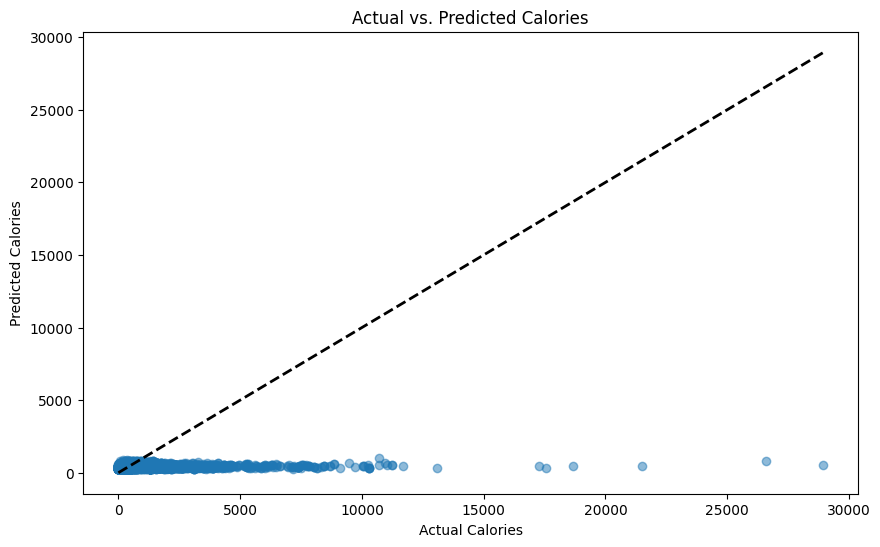

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_base, y_pred_base, alpha=0.5)
plt.title('Actual vs. Predicted Calories')
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.plot([y_test_base.min(), y_test_base.max()], [y_test_base.min(), y_test_base.max()], 'k--', lw=2)
plt.savefig('actual_vs_predicted.png', bbox_inches='tight')


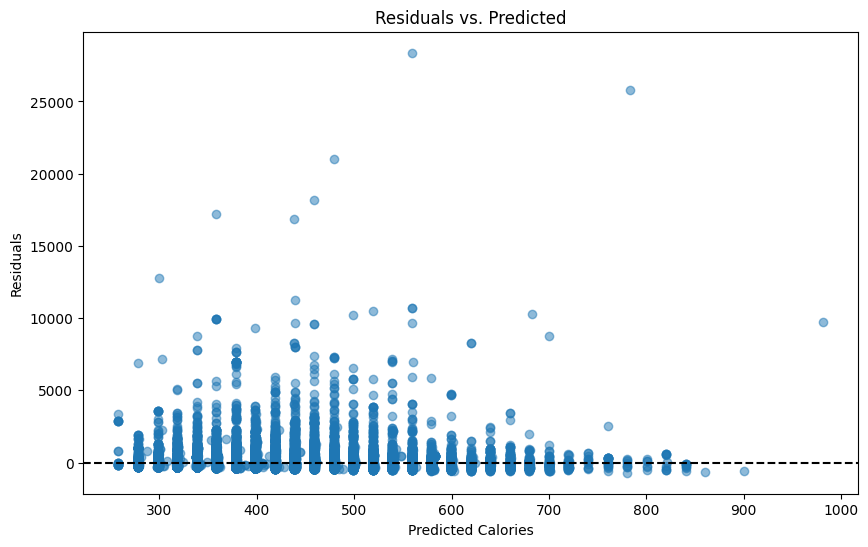

In [19]:
residuals = y_test_base - y_pred_base
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_base, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted Calories')
plt.ylabel('Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.savefig('residuals_plot.png', bbox_inches='tight')


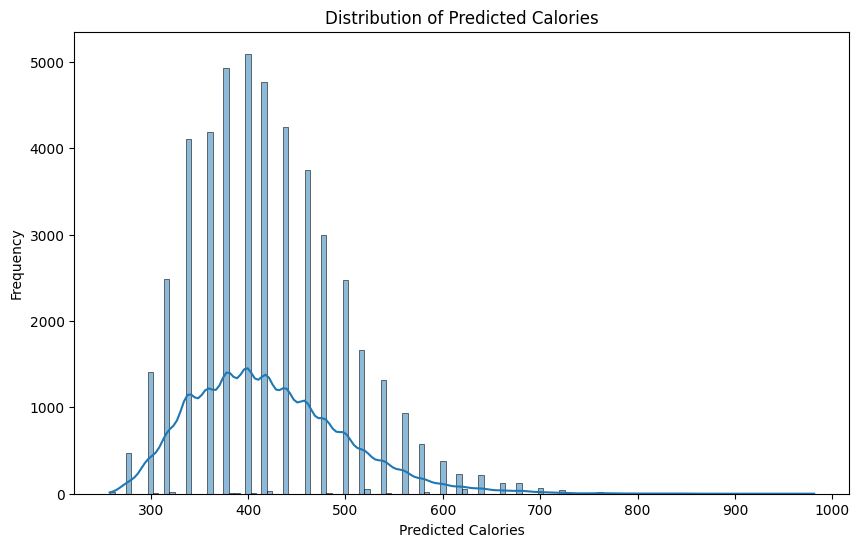

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_base, kde=True)
plt.title('Distribution of Predicted Calories')
plt.xlabel('Predicted Calories')
plt.ylabel('Frequency')
plt.savefig('predicted_distribution.png', bbox_inches='tight')


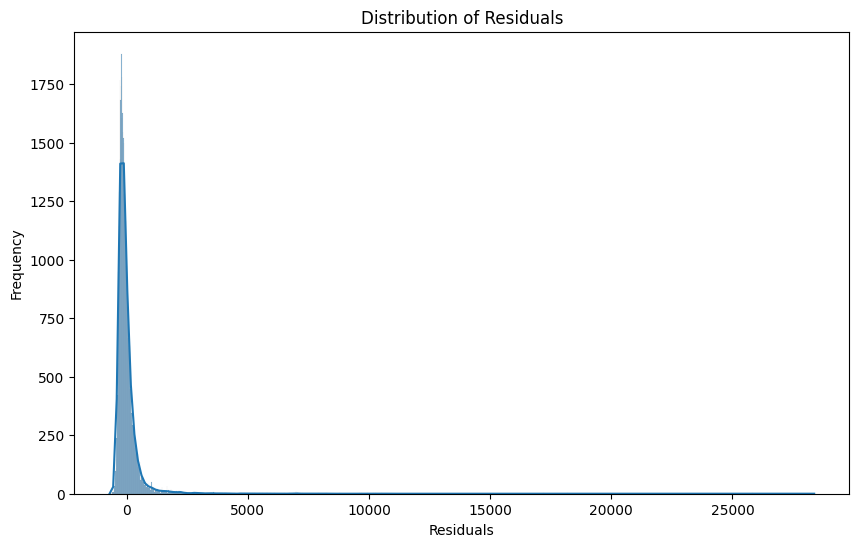

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.savefig('residuals_distribution.png', bbox_inches='tight')


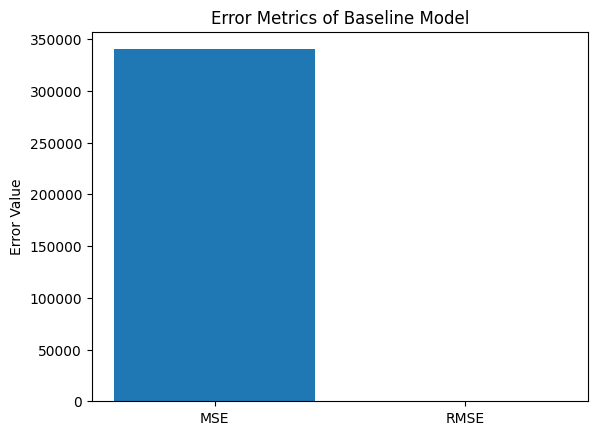

In [22]:
errors = {'MSE': mse_baseline, 'RMSE': rmse_baseline}
plt.bar(errors.keys(), errors.values())
plt.title('Error Metrics of Baseline Model')
plt.ylabel('Error Value')
plt.savefig('error_metrics.png', bbox_inches='tight')


In [25]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def calculate_rmse(y_true, y_pred):
    """Calculate RMSE for given true and predicted values."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Assuming 'recipes_cleaned' is your DataFrame and 'best_model_final' is your trained final model

# Binarizing a column to create two groups
median_value = recipes_cleaned['your_column'].median()  # Replace 'your_column' with the column you want to binarize
recipes_cleaned['group'] = recipes_cleaned['your_column'].apply(lambda x: 'Group1' if x < median_value else 'Group2')

# Splitting the data into two groups
group1 = recipes_cleaned[recipes_cleaned['group'] == 'Group1']
group2 = recipes_cleaned[recipes_cleaned['group'] == 'Group2']

# Select features for prediction
features = ['your', 'list', 'of', 'features']  # Replace with your list of features

# Calculating RMSE for each group using the Final Model
y_pred_group1 = best_model_final.predict(group1[features])
y_pred_group2 = best_model_final.predict(group2[features])

rmse_group1 = calculate_rmse(group1['target_column'], y_pred_group1)  # Replace 'target_column' with your target variable
rmse_group2 = calculate_rmse(group2['target_column'], y_pred_group2)

# Calculating the observed difference in RMSE
observed_difference = rmse_group1 - rmse_group2

# Permutation Test
n_permutations = 1000
differences = []

for _ in range(n_permutations):
    # Shuffling the group labels
    shuffled_groups = recipes_cleaned['group'].sample(frac=1, replace=False).reset_index(drop=True)
    
    # Assigning the shuffled labels to the dataset
    shuffled_data = recipes_cleaned.assign(shuffled_group=shuffled_groups)
    
    # Splitting the data into shuffled groups
    shuffled_group1 = shuffled_data[shuffled_data['shuffled_group'] == 'Group1']
    shuffled_group2 = shuffled_data[shuffled_data['shuffled_group'] == 'Group2']
    
    # Predicting and calculating RMSE for shuffled groups
    y_pred_shuffled_group1 = best_model_final.predict(shuffled_group1[features])
    y_pred_shuffled_group2 = best_model_final.predict(shuffled_group2[features])
    
    rmse_shuffled_group1 = calculate_rmse(shuffled_group1['target_column'], y_pred_shuffled_group1)
    rmse_shuffled_group2 = calculate_rmse(shuffled_group2['target_column'], y_pred_shuffled_group2)
    
    # Calculating the difference in RMSE for the shuffled groups
    difference = rmse_shuffled_group1 - rmse_shuffled_group2
    differences.append(difference)

# Calculating the p-value
p_value = np.mean(np.array(differences) >= observed_difference)

observed_difference, p_value


KeyError: 'your_column'